# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Reference Data

In [2]:
CLUB_NAME_HISTORY = {
    "Thunder FC":"Thunder FC", "Thunder United FC":"Thunder FC", "Real FC United Thunder":"Thunder FC",
    "One Love FC": "One Love FC",
    "Carlos Auto Repair": "Carlos Auto Repair",
    "The Escape Room":"The Escape Room", "The Escapees":"The Escape Room", "Escape Room":"The Escape Room",
    "APEX Charters Lone Pine Brewing":"Lone Pine", "Jibe/Lone Pine":"Lone Pine", "Envy Construction":"Lone Pine",
    "Farmers FC": "Farmers FC",
    "Baxter Pines FC": "Baxter Pines FC",
    "Old Port FC": "Old Port FC",
    "U Gonna Learn Today": "U Gonna Learn Today",
    "Duppy Conquerors": "Duppy Conquerors",
    "Heartbreakers FC": "Heartbreakers FC",
    "Portland Phoenix FC": "Portland Phoenix FC",
    "Midcoast": "Midcoast",
    "The Real Portland Timbers": "The Real Portland Timbers",
    "JW Group": "JW Group",
    "Yankee Ford Sporting Club": "Yankee Ford Sporting Club"
}
LAST_PARTICIPATED_YEARS = {
    "Thunder FC": 2024,
    "One Love FC": 2024,
    "Carlos Auto Repair": 2024,
    "The Escape Room": 2024,
    "Lone Pine": 2024,
    "Farmers FC": 2024,
    "Baxter Pines FC": 2024,
    "Old Port FC": 2024,
    "U Gonna Learn Today": 2023,
    "Duppy Conquerors": 2023,
    "Heartbreakers FC": 2023,
    "Portland Phoenix FC": 2022,
    "Midcoast": 2021,
    "The Real Portland Timbers": 2021,
    "JW Group": 2021,
    "Yankee Ford Sporting Club": 2021
}
TEAM_COLOR={
    "Baxter Pines FC": "#FFA500", # orange
    "Carlos Auto Repair": "#6495ed", # cornflower
    "Duppy Conquerors": "#bdb76b", # darkkhaki
    "Farmers FC": "#006400", # darkgreen
    "Heartbreakers FC": "#ff1493", # deeppink
    "JW Group": "#2f4f4f", # darkslategray
    "Lone Pine": "#00008b", # darkblue
    "Midcoast": "#ffff00", # yellow
    "Old Port FC": "#00ff00", # lime
    "One Love FC": "#afeeee", # paleturquoise
    "Portland Phoenix FC": "#ff0000", # red
    "The Escape Room": "#ff00ff", # fuchsia
    "The Real Portland Timbers": "#00fa9a", # mediumspringgreen
    "Thunder FC": "#800000", # maroon
    "U Gonna Learn Today": "#0000ff", # blue
    "Yankee Ford Sporting Club": "#ffb6c1" # lightpink
}
KAPPA = 2

In [3]:
Elo_ratings = dict()

dfs = pd.read_excel("data/smusl-stats.xlsx", sheet_name=None)

header = ["Date"]+list(set(CLUB_NAME_HISTORY.values()))
df_Elo_ratings = pd.DataFrame(columns=header)

In [4]:
def calculate_G(home_score: int, away_score: int) -> float:
    '''
    A number from the index of goal differences
    '''
    diff = abs(home_score - away_score)
    if diff <= 1: return 1
    elif diff == 2: return 1.5
    else: return (11+diff) / 8

def calculate_K(week: str) -> int:
    '''
    Weight index regarding the tournament of the match
    '''
    if week.startswith("Week"): return 40
    elif week.startswith("Quarter"): return 50
    elif week.startswith("Semi"): return 60
    else: return 80

def calculate_W(home_score: int, away_score: int) -> float:
    '''
    The result of the match
    '''
    if home_score > away_score: return 1
    elif home_score < away_score: return 0
    else: return 0.5

def calculate_delta(r, kappa=2, s=400):
    return 10**(r/s) / (10**(-r/s) + kappa + 10**(r/s))

def round_to_nearest_even(num):
    ceil_num = math.ceil(num)
    floor_num = math.floor(num)
    return ceil_num if ceil_num - num < 0.5 else floor_num

def get_text_color(bg):
    bg_r = int(bg[1:3], 16)
    bg_g = int(bg[3:5] ,16)
    bg_b = int(bg[5:7], 16)

    r = 255 - bg_r
    g = 255 - bg_g
    b = 255 - bg_b

    return f'#{r:02x}{g:02x}{b:02x}'

## Sort by date and add statistics columns

In [5]:
for year in ["2021", "2022", "2023", "2024"]:
    sheet = f"{year}-Match"
    df = dfs[sheet]
    for i in range(len(df.index)):
        row = df.iloc[i]
        month = row["Month"]
        date = row["Date"]
        today_date = pd.to_datetime(f"{year}-{month}-{date}").date()
        df.at[i, "Date"] = today_date
    
    df.sort_values("Date", inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)

    df.insert(len(df.columns), "Elo +/-", [0]*len(df.index))
    df.insert(len(df.columns), "Home Elo", [0]*len(df.index))
    df.insert(len(df.columns), "Away Elo", [0]*len(df.index))
    df.insert(len(df.columns), "Win", [0]*len(df.index))
    df.insert(len(df.columns), "Draw", [0]*len(df.index))
    df.insert(len(df.columns), "Lose", [0]*len(df.index))

# Calculate the Elo rating

In [6]:
idx = -1
for year in ["2021", "2022", "2023", "2024"]:
    zeroth_date = pd.to_datetime(f"{year}-{6}-{1}").date()

    # Check whether the Elo rating exist for each team, if not set it to 1500
    for team in dfs[f"{year}-Table"]["Team"]:
        team = CLUB_NAME_HISTORY[team]
        if team not in Elo_ratings:
            Elo_ratings[team] = [(zeroth_date, 1500)]
        
    sheet = f"{year}-Match"
    df = dfs[sheet]

    prev_date = zeroth_date
    for i in range(len(df.index)):
        row = df.iloc[i]
        home_team = CLUB_NAME_HISTORY[row['Home']]
        away_team = CLUB_NAME_HISTORY[row['Away']]
        date = row["Date"]
        
        home_team_Elo_rating = Elo_ratings[home_team][-1][1]
        away_team_Elo_rating = Elo_ratings[away_team][-1][1]
        home_team_score = row['Home Score']
        away_team_score = row['Away Score']

        df.at[i, "Home Elo"] = round(home_team_Elo_rating, 2)
        df.at[i, "Away Elo"] = round(away_team_Elo_rating, 2)

        # Calculate the Expected result of the match 
        W_e = 1 / (10**(-(home_team_Elo_rating - away_team_Elo_rating)/400)+1)

        # Calculate the Points Chnage
        K = calculate_K(row["Week"])
        G = calculate_G(home_team_score, away_team_score)
        W = calculate_W(home_team_score, away_team_score)
        P = K*G*(W-W_e)
        df.at[i, "Elo +/-"] = round(P,2)
        
        # log the match odd and the Elo ratings exchange
        r = home_team_Elo_rating - away_team_Elo_rating
        pr_home_win = calculate_delta(r, KAPPA)
        pr_away_win = calculate_delta(-r, KAPPA)

        df.at[i, "Win"] = round_to_nearest_even(pr_home_win * 100)
        df.at[i, "Lose"] = round_to_nearest_even(pr_away_win * 100)
        df.at[i, "Draw"] = 100 - df.at[i, "Win"] - df.at[i, "Lose"]

        # Calculate the new ratings
        new_home_team_Elo_rating = home_team_Elo_rating + P
        new_away_team_Elo_rating = away_team_Elo_rating - P

        Elo_ratings[home_team].append((date, new_home_team_Elo_rating))
        Elo_ratings[away_team].append((date, new_away_team_Elo_rating))

        # fill the df_Elo_ratings
        row_Elo_ratings = {"Date": str(date), home_team: new_home_team_Elo_rating, away_team: new_away_team_Elo_rating}
        if prev_date != date:
            idx += 1
            df_Elo_ratings.loc[idx] = row_Elo_ratings 
        else:
            df_Elo_ratings.at[idx, home_team] = new_home_team_Elo_rating
            df_Elo_ratings.at[idx, away_team] = new_away_team_Elo_rating
        
        prev_date = date

# Fill the gap

In [7]:
joined_teams = dict()
for team in set(CLUB_NAME_HISTORY.values()):
    joined_teams[team] = False 

for i in range(len(df_Elo_ratings.index)):
    for col, _ in df_Elo_ratings.items():
        if col == "Date": continue
        if pd.isna(df_Elo_ratings.at[i, col]) and joined_teams[col] and LAST_PARTICIPATED_YEARS[col] >= int(df_Elo_ratings.at[i, "Date"][:4]):
            df_Elo_ratings.at[i, col] = df_Elo_ratings.at[i-1, col]
        else: 
            joined_teams[col] = True

# Plot

In [ ]:
plt.figure(figsize=(20,30))

plt.plot(df_Elo_ratings["Date"], [1500]*len(df_Elo_ratings.index), 'k--', linewidth=1)
plt.axvline(x="2022-06-14", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2023-06-08", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2024-06-11", color = 'k', ls = '-.', linewidth=1)

SEASON_TEXT_Y_COORDINATE = 1975
plt.text("2021-08-12", SEASON_TEXT_Y_COORDINATE, "2021", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2022-08-16", SEASON_TEXT_Y_COORDINATE, "2022", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2023-08-17", SEASON_TEXT_Y_COORDINATE, "2023", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2024-06-25", SEASON_TEXT_Y_COORDINATE, "2024", horizontalalignment='left', weight="bold", fontsize='xx-large')

for col, _ in df_Elo_ratings.items():
    if col == "Date": continue
    plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col, color=TEAM_COLOR[col])

    for i in range(len(df_Elo_ratings)-1,-1,-1):
        if not pd.isna(df_Elo_ratings.at[i, col]):
            plt.text(df_Elo_ratings.at[i, "Date"], df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", rotation=-30)
            break

_, right = plt.xlim()
plt.xlim(["2021-06-22", right])
plt.ylim([1200, 2000])
plt.legend(loc="lower right", ncol=2)
plt.xticks(rotation=-60, ha="left", rotation_mode="anchor", fontsize="small")

plt.savefig("./fig/elo-ratings-bar-chart-all.png", bbox_inches='tight')
# plt.show()

In [ ]:
for team_name, team_color in TEAM_COLOR.items():
    plt.figure(figsize=(20,30))

    plt.plot(df_Elo_ratings["Date"], [1500]*len(df_Elo_ratings.index), 'k--', linewidth=1)
    plt.axvline(x="2022-06-14", color = 'k', ls = '-.', linewidth=1)
    plt.axvline(x="2023-06-08", color = 'k', ls = '-.', linewidth=1)
    plt.axvline(x="2024-06-11", color = 'k', ls = '-.', linewidth=1)

    SEASON_TEXT_Y_COORDINATE = 1975
    plt.text("2021-08-12", SEASON_TEXT_Y_COORDINATE, "2021", horizontalalignment='center', weight="bold", fontsize='xx-large')
    plt.text("2022-08-16", SEASON_TEXT_Y_COORDINATE, "2022", horizontalalignment='center', weight="bold", fontsize='xx-large')
    plt.text("2023-08-17", SEASON_TEXT_Y_COORDINATE, "2023", horizontalalignment='center', weight="bold", fontsize='xx-large')
    plt.text("2024-06-25", SEASON_TEXT_Y_COORDINATE, "2024", horizontalalignment='left', weight="bold", fontsize='xx-large')

    for col, _ in df_Elo_ratings.items():
        if col == "Date": continue
        if col == team_name: plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col, linewidth=7.0, color=team_color)
        else: plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col, color=TEAM_COLOR[col])

        for i in range(len(df_Elo_ratings)-1,-1,-1):
            if not pd.isna(df_Elo_ratings.at[i, col]):
                if col == team_name: plt.text(df_Elo_ratings.at[i, "Date"], df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", backgroundcolor = team_color, rotation=-30, color=get_text_color(team_color))
                else: plt.text(df_Elo_ratings.at[i, "Date"], df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", rotation=-30)
                break

    _, right = plt.xlim()
    plt.xlim(["2021-06-22", right])
    plt.ylim([1200, 2000])
    plt.legend(loc="lower right", ncol=2)
    plt.xticks(rotation=-60, ha="left", rotation_mode="anchor", fontsize="small")
    
    team_name = team_name.replace(" ", "-").lower()
    plt.savefig(f"fig/elo-ratings-bar-chart-{team_name}.png", bbox_inches='tight')

    # plt.show()

    

In [10]:
Elo_ratings_teams = dict()
for team in Elo_ratings.keys():
    Elo_ratings_teams[team] = round(Elo_ratings[team][-1][1])
for team, rating in sorted(Elo_ratings_teams.items(), key=lambda item: -item[1]):
    print(f"{team : >35}: {rating}")

                U Gonna Learn Today: 1964
                         Thunder FC: 1710
                   Duppy Conquerors: 1670
                         Farmers FC: 1646
                        One Love FC: 1551
                 Carlos Auto Repair: 1544
                           Midcoast: 1511
                        Old Port FC: 1467
                          Lone Pine: 1446
                Portland Phoenix FC: 1439
                    Baxter Pines FC: 1415
                    The Escape Room: 1392
          The Real Portland Timbers: 1342
                           JW Group: 1314
                   Heartbreakers FC: 1312
          Yankee Ford Sporting Club: 1278


## Calculate the biggest upset

In [19]:
matches_list = []
for year in ["2021", "2022", "2023", "2024"]:
    sheet = f"{year}-Match"
    df = dfs[sheet]
    matches_list.append(df)
    
df_all_matches = pd.concat(matches_list)
df_all_matches.drop(columns=["Month"]).to_csv("data/match.csv", index=False)
df_biggest_upset = df_all_matches.sort_values("Elo +/-")[["Date", "Week", "Home", "Away", "Home Elo", "Away Elo", "Win", "Draw", "Lose", "Home Score", "Away Score", "Elo +/-"]].head(10)
df_biggest_upset.to_csv("data/biggest_upset.csv", index=False)

# Calculate the Most Unexpected

In [16]:
cols = ["Win", "Lose"]
df_all_matches.reset_index(inplace=True)
df_most_unexpected = df_all_matches[((df_all_matches["Win"] > df_all_matches["Lose"]) & (df_all_matches["Home Score"] < df_all_matches["Away Score"])) | ((df_all_matches["Win"] < df_all_matches["Lose"]) & (df_all_matches["Home Score"] > df_all_matches["Away Score"]))][["Date", "Week", "Home", "Away", "Home Elo", "Away Elo", "Win", "Draw", "Lose", "Home Score", "Away Score", "Elo +/-"]].assign(_min=df_all_matches[cols].min(axis=1)+df_all_matches["Draw"], _other=df_all_matches[cols].max(axis=1)+df_all_matches["Draw"]).sort_values(["_min","_other"]).drop(columns=["_min","_other"]).head(10)
df_most_unexpected.to_csv("data/most_unexpected.csv", index=False)


# Previous Work

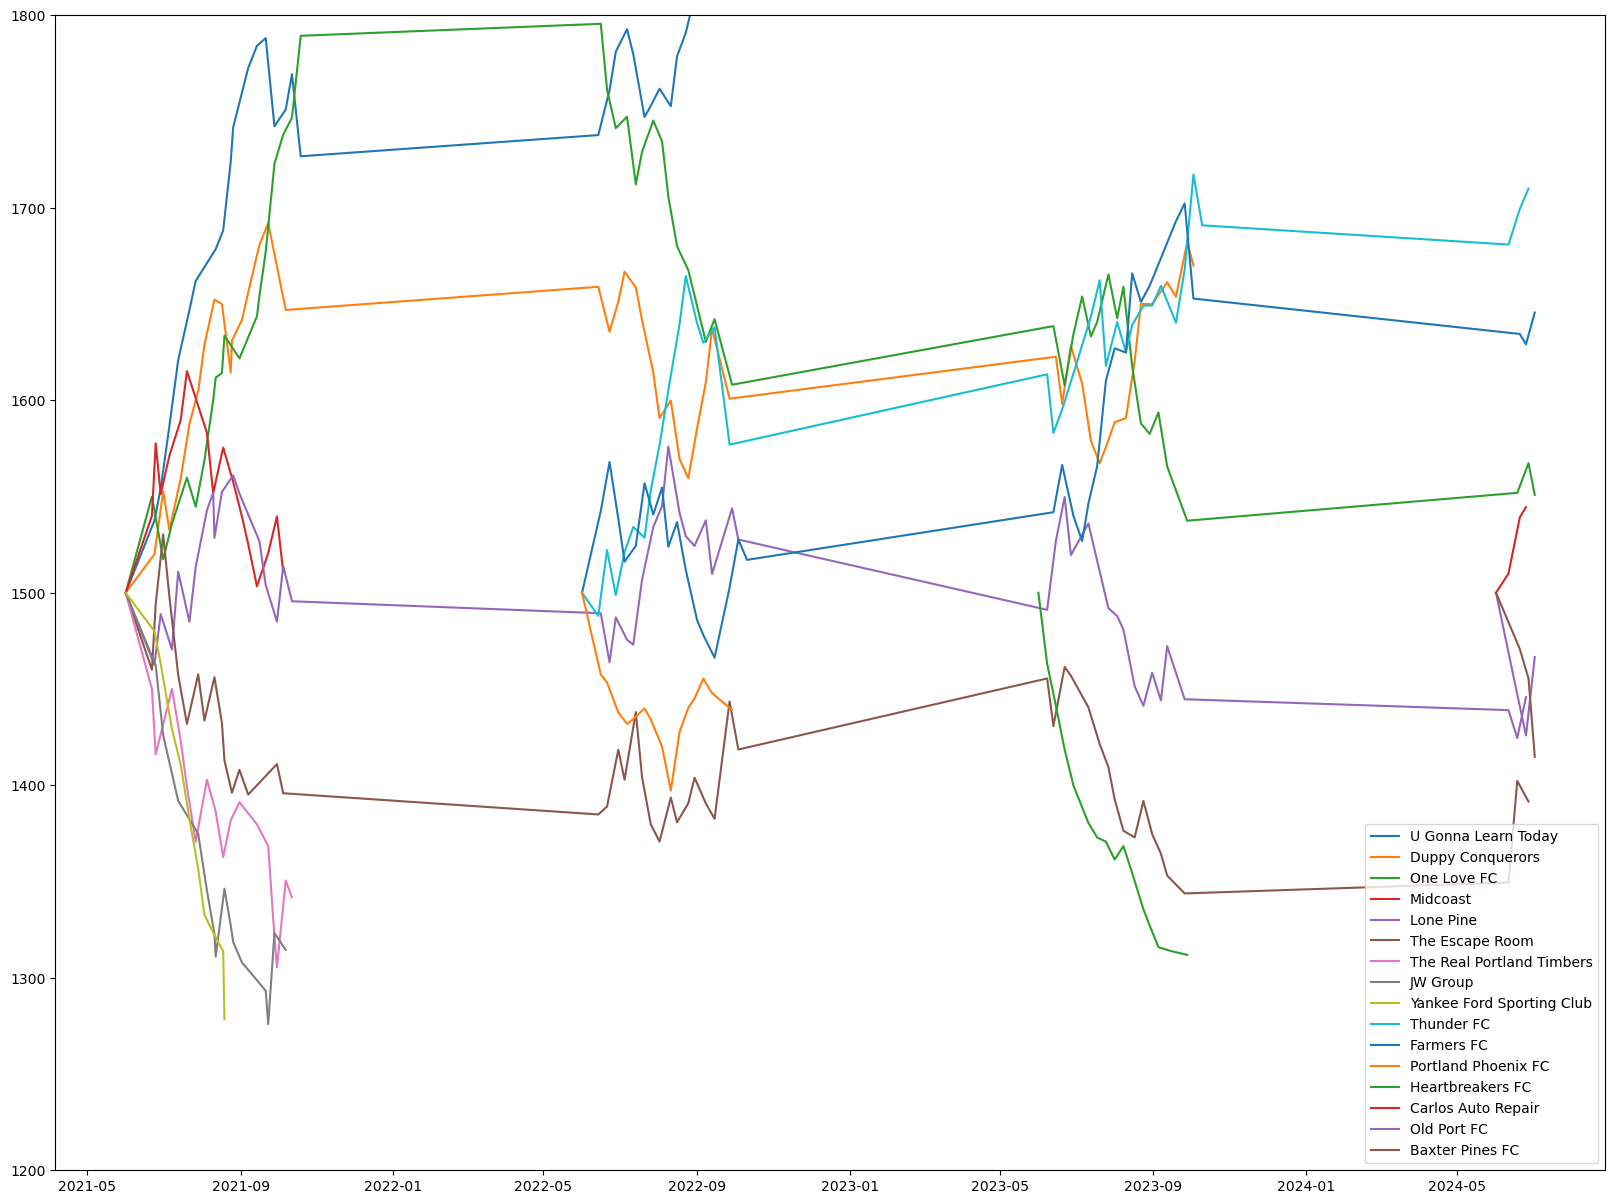

In [13]:
plt.figure(figsize=(20,15))
for team in Elo_ratings.keys():
    Elo_ratings_team = np.array(Elo_ratings[team])
    plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team)
plt.legend(loc="lower right")
plt.ylim(1200, 1800)
plt.show()

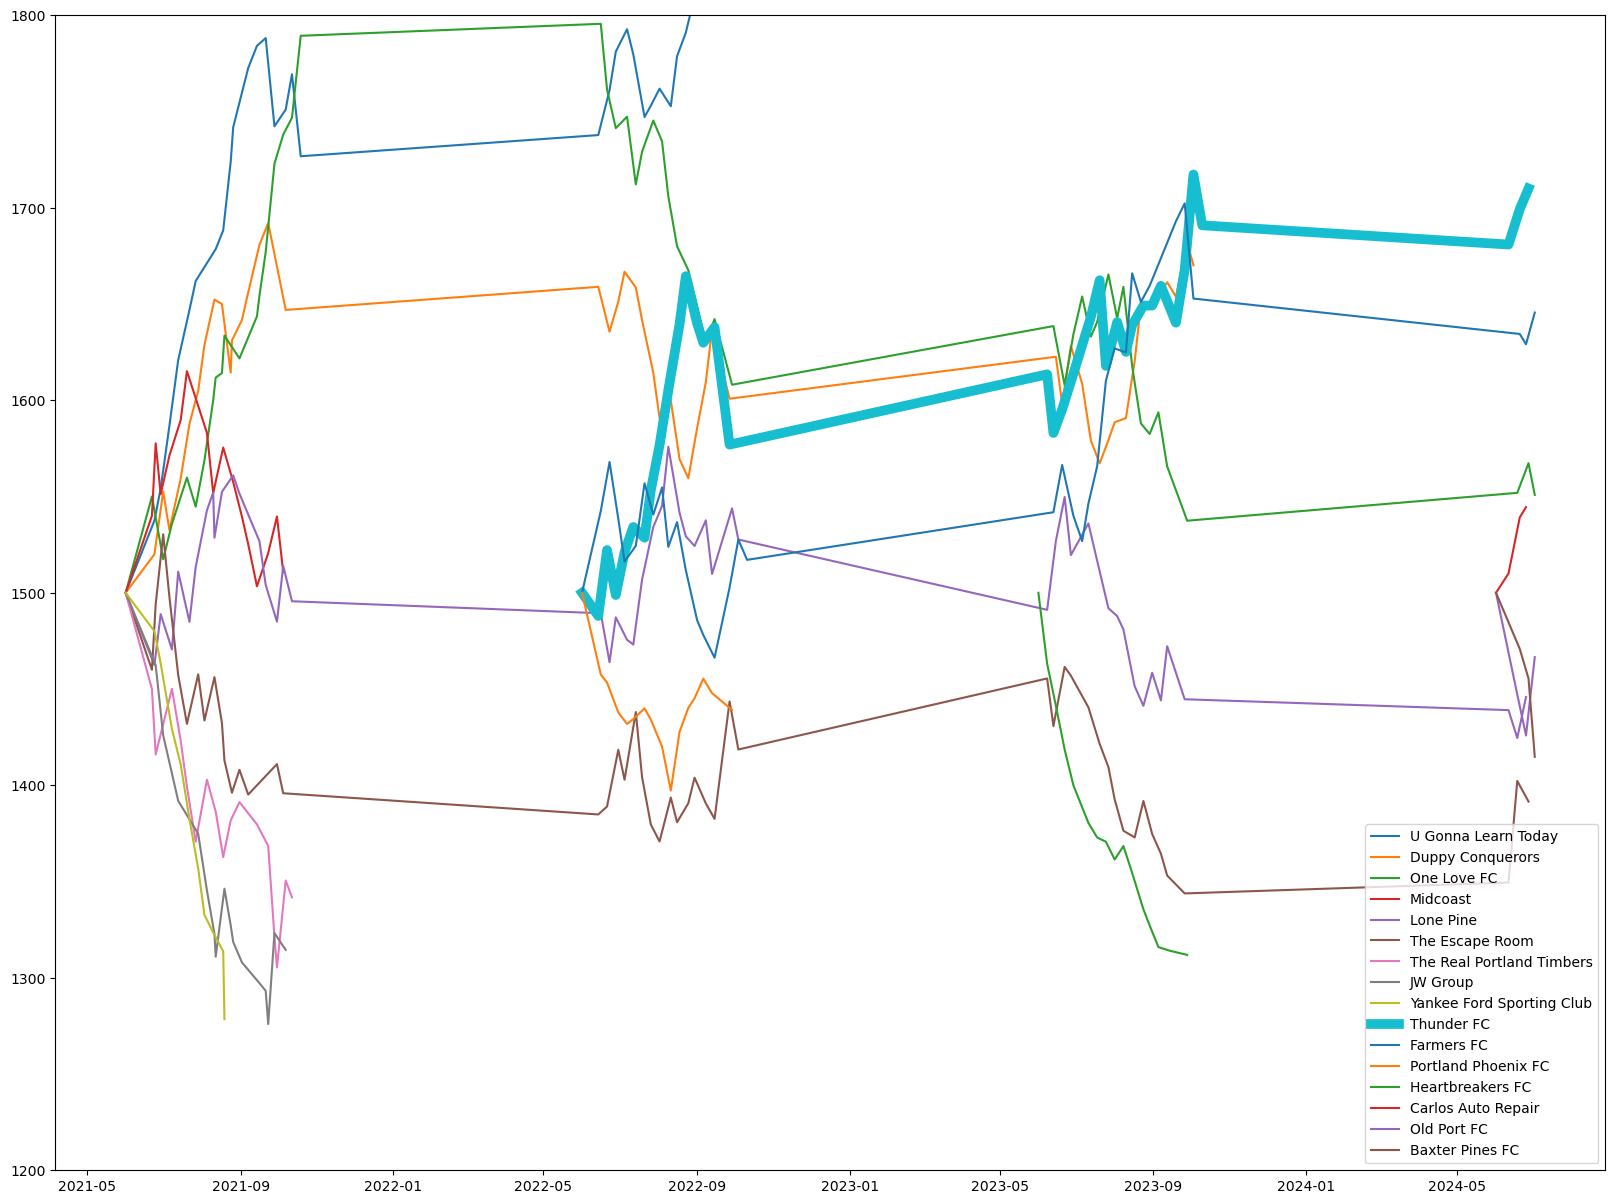

In [14]:
plt.figure(figsize=(20,15))
for team in Elo_ratings.keys():
    Elo_ratings_team = np.array(Elo_ratings[team])
    if team == "Thunder FC":
        plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team, linewidth=7.0)
    else:
        plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team)
plt.legend(loc="lower right")
plt.ylim(1200, 1800)
plt.show()